<a href="https://colab.research.google.com/github/Jacobluke-/FYPI/blob/main/Pytorch_Tutorial/Classifying_names.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

['data/names/Korean.txt', 'data/names/Czech.txt', 'data/names/Spanish.txt', 'data/names/Russian.txt', 'data/names/Polish.txt', 'data/names/Chinese.txt', 'data/names/German.txt', 'data/names/Scottish.txt', 'data/names/Portuguese.txt', 'data/names/Japanese.txt', 'data/names/Irish.txt', 'data/names/Greek.txt', 'data/names/French.txt', 'data/names/English.txt', 'data/names/Dutch.txt', 'data/names/Italian.txt', 'data/names/Arabic.txt', 'data/names/Vietnamese.txt']


In [4]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ascii
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
      and c in all_letters
  )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

def readLines(filename):
  lines = open(filename, encoding = 'utf-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines
  

n_categories = len(all_categories)
print(category_lines['Italian'][:5])


Slusarski
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [5]:
# 我们获得了一个变量 category_lines，而这是一个字典，所以则是类别（语言），
# 对应值是一个列表，其中包含多行数据（姓氏）
# 同时，还保存了 all_categories （语言列表） 以及 n_categories（语言数量）

## 将姓氏转换为张量
为了表示单个字母，我们使用大小为<1 x n_letters>的“ one-hot vector”。 一个“one hot”向量是当前字母的索引处为 1，其余部分为 0 的向量，例如 "b" = <0 1 0 0 0 ...>。

我们将每行的所有字母的“one hot”向量连接成 2D 矩阵<line_length x 1 x n_letters>来表示一个单词（姓氏）。

额外的 1 维是因为 PyTorch 假设所有内容都是批量的-我们这里批量大小为 1 。

In [6]:
import torch
a = torch.zeros(1,26)
a[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [7]:
import torch

def letterToIndex(letter):
  return all_letters.find(letter)

def letterToTensor(letter):
  tensor = torch.zeros(1,n_letters)
  tensor[0][letterToIndex(letter)] = 1
  return tensor

def lineToTensor(line):
  tensor = torch.zeros(len(line),1,n_letters)
  for li, letter in enumerate(line):
    tensor[li][0][letterToIndex(letter)]=1
  return tensor

In [8]:
print(n_letters)
print(all_letters.find("r"))
a = letterToTensor("r")
print(a)
print(lineToTensor('Jacob'))
print(lineToTensor('Jacob').size())

57
17
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 

In [13]:
# Construct a neural network

import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size

    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim = 1)

  def forward(self, input, hidden):
    combined = torch.cat((input, hidden),1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
rnn = rnn.to("cpu")

先测试单步运行， 传递一个字母的张量与上一步的隐藏状态（初始化其为0）。 返回的结果是每种语言的概率与下一步的隐藏状态（保留至下一步使用）。

In [15]:
input = letterToTensor('Jacob')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output, "\n", next_hidden)

tensor([[-2.8534, -2.8470, -3.0178, -2.8432, -2.8908, -2.8969, -2.9002, -2.9461,
         -2.9807, -2.8321, -2.8949, -2.8455, -2.8825, -2.8410, -2.8601, -2.7992,
         -3.0060, -2.9211]], grad_fn=<LogSoftmaxBackward>) 
 tensor([[ 0.0796,  0.0107, -0.0066,  0.0239, -0.0426, -0.1005, -0.0425, -0.0266,
         -0.0513, -0.0482,  0.0301,  0.0003,  0.0208, -0.0097, -0.0523,  0.0296,
          0.0516, -0.0098, -0.0239,  0.0189,  0.0845,  0.0237, -0.0879,  0.0523,
          0.0002,  0.0611,  0.1024, -0.0136,  0.0733,  0.0496,  0.0034,  0.0309,
          0.0701,  0.0449, -0.1053, -0.0164,  0.0585, -0.1021,  0.0418,  0.0068,
          0.1221, -0.0003,  0.0386, -0.0810, -0.0309,  0.0941,  0.0782,  0.0572,
          0.0488, -0.0106, -0.0630,  0.0176, -0.0514,  0.0295, -0.0274,  0.0231,
         -0.1108,  0.0208, -0.1021, -0.0168, -0.0849, -0.0196, -0.0785, -0.0193,
          0.0215,  0.0935, -0.0419,  0.0909,  0.0216,  0.0371,  0.0315, -0.0249,
         -0.0153,  0.0479, -0.0082, -0.1152, -0.

In [16]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))
print(output.topk(1))
print(category_lines['Arabic'])


tensor([[-2.8537, -2.8639, -2.9756, -2.8076, -2.9326, -2.9564, -2.8244, -2.9237,
         -2.9540, -2.8052, -2.8789, -2.9053, -2.9938, -2.8552, -2.9147, -2.7978,
         -2.8991, -2.9156]], grad_fn=<LogSoftmaxBackward>)
('Italian', 15)
torch.return_types.topk(
values=tensor([[-2.7978]], grad_fn=<TopkBackward>),
indices=tensor([[15]]))
['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari', 'Maalouf', 'Gerges', 'Naifeh', 'Guirguis', 'Baba', 'Sabbagh', 'Attia', 'Tahan', 'Haddad', 'Aswad', 'Najjar', 'Dagher', 'Maloof', 'Isa', 'Asghar', 'Nader', 'Gaber', 'Abboud', 'Maalouf', 'Zogby', 'Srour', 'Bahar', 'Mustafa', 'Hanania', 'Daher', 'Tuma', 'Nahas', 'Saliba', 'Shamoon', 'Handal', 'Baba', 'Amari', 'Bahar', 'Atiyeh', 'Said', 'Khouri', 'Tahan', 'Baba', 'Mustafa', 'Guirguis', 'Sleiman', 'Seif', 'Dagher', 'Bahar', 'Gaber', 'Harb', 'Seif', 'Asker', 'Nader', 'Antar', 'Awad', 'Srour', 'Shadid', 'Hajjar', 'Hanania', 'Kalb', 'Shadid', 'Bazzi', 'Mustafa', 'Masih', 'Ghanem', 'Haddad', 'Isa', 'Antoun', 'Sarra

In [17]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Vietnamese / line = Nguyen
category = Czech / line = Furtsch
category = Russian / line = Finoshin
category = Vietnamese / line = Doan
category = Arabic / line = Hajjar
category = Vietnamese / line = Ha
category = French / line = Cornett
category = Japanese / line = Irie
category = Vietnamese / line = Luu
category = Scottish / line = Kerr


In [18]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [20]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

#当前时刻的 loss，用于画图
current_loss = 0
all_losses = []

def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s/60)
  s -= m*60
  return '%dm %ds' % (m,s)

start = time.time()

for iter in range(1, n_iters + 1):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = train(category_tensor, line_tensor)
  current_loss += loss

  #printing
  if iter % print_every == 0:
    guess, guess_i = categoryFromOutput(output)
    correct = '✓' if guess == category else '✗ (%s)' % category
    print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

  #
  if iter % plot_every == 0:
    all_losses.append(current_loss/plot_every)
    current_loss = 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)


5000 5% (0m 4s) 2.1694 Liu / Chinese ✓
10000 10% (0m 9s) 1.5467 Rudaski / Polish ✓
15000 15% (0m 14s) 5.3878 Zhuk / Korean ✗ (Russian)
20000 20% (0m 18s) 0.3692 Petimezas / Greek ✓
25000 25% (0m 23s) 1.2685 Zabek / Polish ✓
30000 30% (0m 28s) 1.1826 Tow / Korean ✗ (Chinese)
35000 35% (0m 33s) 1.6748 Abreu / Spanish ✗ (Portuguese)
40000 40% (0m 37s) 1.8329 Freund / Vietnamese ✗ (German)
45000 45% (0m 42s) 2.0262 Aleshite / French ✗ (German)
50000 50% (0m 47s) 0.7658 Weber / German ✓
55000 55% (0m 51s) 1.0902 Ra / Korean ✓
60000 60% (0m 56s) 1.3122 Guirguis / Arabic ✓
65000 65% (1m 0s) 1.8520 Boerio / Portuguese ✗ (Italian)
70000 70% (1m 5s) 0.3090 Slapnickova / Czech ✓
75000 75% (1m 10s) 0.3525 Ryom / Korean ✓
80000 80% (1m 14s) 1.2783 Belo / Spanish ✗ (Portuguese)
85000 85% (1m 19s) 4.0460 Can / Chinese ✗ (Dutch)
90000 90% (1m 24s) 1.5937 Guillory / English ✗ (French)
95000 95% (1m 28s) 1.6809 Cardozo / Spanish ✗ (Portuguese)
100000 100% (1m 33s) 0.9729 Tse / Chinese ✓


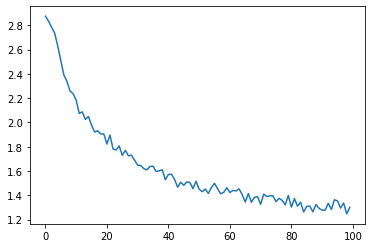

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

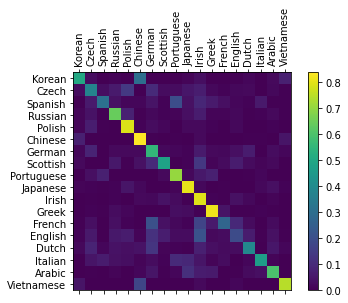

In [22]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()